**Member 1 (S.Kestroy / ITBIN-2211-0207)**

**1. Identify The Problem**

There is a significant problem with the immediate propagation of false or misinformed messages on applications such as WhatsApp, SMS and social media. They consist of short, informal messages that can hardly be found by applying the traditional methods and result in missed threats or falsely identified flags. With increased digital communication, unrestricted proliferation of incorrect messages may lead to widespread confusion in the population, panic, manipulation, and loss of money and, therefore, timely and correct identification is required.


**Imports for Loading**

In [77]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing helpers
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**2. Data Understanding**

**2.1 Data Collection**

In [78]:
# Data Loading
data_fake = pd.read_csv("Fake.csv", engine='python', on_bad_lines='skip')
data_real = pd.read_csv("True.csv", engine='python', on_bad_lines='skip' )

In [79]:
# Add label to the data
data_fake['label'] = 'FAKE'
data_real['label'] = 'REAL'

In [80]:
# Merge the Datasets
dataset = pd.concat([data_fake, data_real], ignore_index=True)

**2.2 Initial Overview**

In [81]:
# Quick Overview
print(dataset.shape)
display(dataset.head())


(44898, 5)


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",FAKE
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",FAKE
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",FAKE
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",FAKE
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",FAKE


In [82]:
#Data Types and nulls
print(dataset.info())
print(dataset.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB
None
title      0
text       0
subject    0
date       0
label      0
dtype: int64


**2.3 Summary Statistics**

In [83]:
# For numeric columns (we'll add a few numeric features later)
print(dataset.describe(include='all'))

                                                    title   text  \
count                                               44898  44898   
unique                                              38729  38646   
top     Factbox: Trump fills top jobs for his administ...          
freq                                                   14    627   

             subject                date  label  
count          44898               44898  44898  
unique             8                2397      2  
top     politicsNews  December 20, 2017    FAKE  
freq           11272                 182  23481  


In [84]:
# Class distribution
print(dataset['label'].value_counts())

label
FAKE    23481
REAL    21417
Name: count, dtype: int64


**2.4 Visualize the Key aspects**

In [85]:
# Compute combined text and text length first
dataset['content'] = dataset['title'].fillna('') + " " + dataset['text'].fillna('')
dataset['textLength'] = dataset['content'].apply(lambda x: len(str(x)))


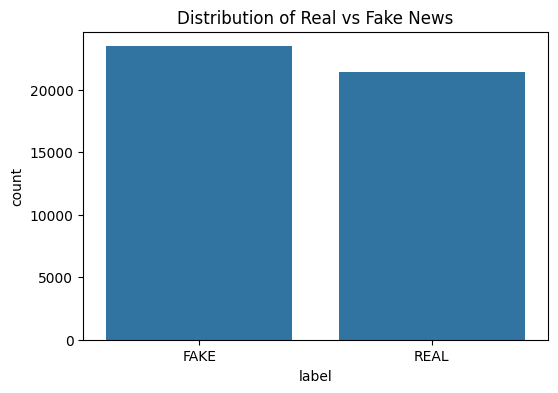

In [86]:
# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=dataset, x='label')
plt.title('Distribution of Real vs Fake News')
plt.show()

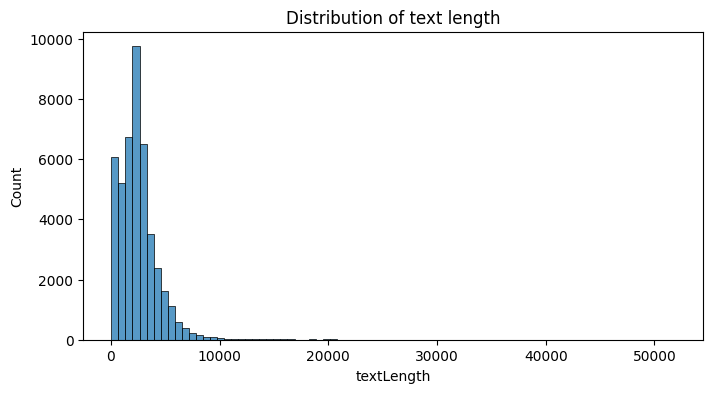

In [87]:
# text length histogram
plt.figure(figsize=(8,4))
sns.histplot(dataset['textLength'], bins=80)
plt.title('Distribution of text length')
plt.show()

**2.5 Identify issues**

In [88]:
# missing values per column
print(dataset.isnull().sum())

title         0
text          0
subject       0
date          0
label         0
content       0
textLength    0
dtype: int64


In [89]:
# duplicates (on content)
print("Duplicates:", dataset['content'].duplicated().sum())

Duplicates: 5793


In [90]:
# extreme text length outliers
q1 = dataset['textLength'].quantile(0.01)
q99 = dataset['textLength'].quantile(0.99)
print("1% of length:", q1 )
print("99% of length:", q99)

1% of length: 100.0
99% of length: 9340.0


In [91]:
# show a few very long entries
display(dataset[dataset['textLength'] > q99].head())

,title,text,subject,date,label,content,textLength
2639,Trump’s List Of ‘Unreported Terror Attacks’ A...,"In another of Donald Trump s whine rests, the ...",News,"February 7, 2017",FAKE,Trump’s List Of ‘Unreported Terror Attacks’ A...,13186
4147,Here’s The Master List Of Reasons Why Trump W...,We know Trump is a sexual predator. We know he...,News,"October 18, 2016",FAKE,Here’s The Master List Of Reasons Why Trump W...,15302
4475,Here You Go: Every Bat Sh*t Crazy Thing That ...,Donald Trump spent Monday night making a total...,News,"September 27, 2016",FAKE,Here You Go: Every Bat Sh*t Crazy Thing That ...,20356
7715,Fed Up Republicans Threaten Third Party Optio...,I ve been saying for a long time now that the ...,News,"March 3, 2016",FAKE,Fed Up Republicans Threaten Third Party Optio...,26806
8111,The Top Ten Reasons We NEED A Liberal Supreme...,"One way or another, the passing of Supreme Cou...",News,"February 14, 2016",FAKE,The Top Ten Reasons We NEED A Liberal Supreme...,10173


**3. Data PrePrecessing**

In [92]:
import html
import re
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # remove html escapes
    text = html.unescape(text)
    # remove urls
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # keep letters/numbers/space
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)
    # lowercase
    text = text.lower()
    # tokenize using regex
    tokens = re.findall(r'\b\w+\b', text)
    tokens = [t for t in tokens if t not in STOPWORDS and not t.isdigit()]
    return ' '.join(tokens)

In [93]:
# Apply (may be slow on millions of rows; sample or batch)
dataset['clean_text'] = dataset['content'].apply(clean_text)

**3.1 remove incorrect data**

In [94]:
# Drop rows where clean_text is empty
dataset['clean_text'] = dataset['clean_text'].astype(str)
dataset = dataset[dataset['clean_text'].str.strip() != ""].copy()
print("Dataset shape after cleaning:", dataset.shape)


Dataset shape after cleaning: (44889, 8)


**3.2 Handle Duplicates**

In [95]:
dataset = dataset.drop_duplicates(subset=['clean_text']).reset_index(drop=True)

**3.3 Handling missing Values**

In [96]:
# For Subject
dataset['subject'] = dataset['subject'].fillna(dataset['subject'].mode()[0])

In [97]:
#For Numeric
dataset['textLength'] = dataset['textLength'].fillna(dataset['textLength'].median())

**3.4 Binning**

In [98]:
# Equal-width bins
bins = [0, 50, 200, 500, 1000, dataset['textLength'].max()+1]
labels = ['very_short', 'short', 'medium', 'long', 'very_long']
dataset['length_bin'] = pd.cut(dataset['textLength'], bins=bins, labels=labels, include_lowest=True)

In [99]:
# Replace bin values with bin mean
bin_mean = dataset.groupby('length_bin')['textLength'].transform('mean')
dataset['length_bin_mean'] = bin_mean

/tmp/ipython-input-3186026227.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_mean = dataset.groupby('length_bin')['textLength'].transform('mean')


**3.5 regression**

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [101]:
# Vectorize a sample
sample = dataset.sample(n=min(1000, len(dataset)), random_state=42)
vect = TfidfVectorizer(max_features=5000)
X = vect.fit_transform(sample['clean_text'])

kmeans = KMeans(n_clusters=6, random_state=42, n_init=10) # Added n_init to suppress future warning
sample['cluster'] = kmeans.fit_predict(X)

In [102]:
# Show distribution per cluster
print(sample['cluster'].value_counts())

cluster
3    410
0    231
1     93
2     93
4     87
5     86
Name: count, dtype: int64


**4. Reduction**

**4.1 Dimensionality reduction**

In [103]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# create TF-IDF for full
vect = TfidfVectorizer(max_df=0.7, min_df=5, max_features=20000)
X_tfidf = vect.fit_transform(dataset['clean_text'].sample(n=1000, random_state=42))  # sample for speed

svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

**4.2 Attribute subset selection**

In [104]:
from sklearn.feature_selection import SelectKBest, chi2

# For selection we need numeric X and y
y_sample = (dataset['label'].sample(n=3882, random_state=42) == 'FAKE').astype(int)
X_sample = vect.transform(dataset['clean_text'].sample(n=3882, random_state=42))

selector = SelectKBest(chi2, k=2000)
X_selected = selector.fit_transform(X_sample, y_sample)

**4.3 Numerosity reduction**

In [105]:
from sklearn.model_selection import train_test_split

# Stratified subsampling: keep 80% for training
df_train, df_test = train_test_split(dataset, train_size=0.8, stratify=dataset['label'], random_state=42)
print("Training set size:", df_train.shape[0])
print("Testing set size:", df_test.shape[0])
print("\nTraining set label distribution:\n", df_train['label'].value_counts())
print("\nTesting set label distribution:\n", df_test['label'].value_counts())

Training set size: 31060
Testing set size: 7766

Training set label distribution:
 label
REAL    16740
FAKE    14320
Name: count, dtype: int64

Testing set label distribution:
 label
REAL    4186
FAKE    3580
Name: count, dtype: int64


**5. Transformation**

**5.1 Normalize numeric features**

In [106]:
from sklearn.preprocessing import StandardScaler

# Example numeric features
dataset['word_count'] = dataset['clean_text'].apply(lambda x: len(x.split()))
dataset['avg_word_len'] = dataset['clean_text'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)

scaler = StandardScaler()
dataset[['word_count_s', 'avg_word_len_s']] = scaler.fit_transform(dataset[['word_count', 'avg_word_len']])

**5.2 Feature engineering**

In [107]:
# stopword count
dataset['stopword_count'] = dataset['content'].apply(lambda x: sum(1 for w in str(x).split() if w.lower() in STOPWORDS))


In [108]:
# punctuation count
dataset['punct_count'] = dataset['content'].apply(lambda x: sum(1 for c in str(x) if c in string.punctuation))


In [109]:
# uppercase ratio
dataset['upper_ratio'] = dataset['content'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / (len(str(x)) + 1))


**5.3 Discretization**

In [110]:
#  discretize word_count into 4 bins
dataset['word_count_bin'] = pd.qcut(dataset['word_count'], q=4, labels=False)

**5.4 Concept hierarchy generation**

In [111]:
# Example mapping
mapping = {
    'Politics': 'News',
    'World': 'News',
    'Health': 'Health',
    'Science': 'Science',
    'Tech': 'Technology',
    'Business': 'Business'
}

# Create 'subject_top' column in the dataset DataFrame
dataset['subject_top'] = dataset['subject'].map(mapping).fillna('Other')

**6. Save Cleaned Data**

In [112]:
# Keep columns needed for modeling
cols_to_save = ['title', 'clean_text', 'label', 'textLength', 'word_count', 'avg_word_len',
                'stopword_count', 'punct_count', 'upper_ratio', 'subject_top']
df_model = dataset[cols_to_save].copy()

df_model.to_csv("cleaned_Dataset.csv", index=False)
print("Saved:", df_model.shape)

Saved: (38826, 10)


**Member 2 (N. Krishnapriyan / ITBIN-2211-0208)**

**DATA MINING & MACHINE LEARNING**

 Apply Data Mining Tasks

In [114]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [115]:
# Split dataset
X = dataset['clean_text']
y = dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
# Convert text → numerical features (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

**Train Models**

(a) Logistic Regression

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance classes in training set
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_tfidf2, y_train)

# Train on balanced data
log_model = LogisticRegression(max_iter=500, class_weight="balanced")
log_model.fit(X_train_tfidf2, y_train)

LogisticRegression(max_iter=200)

(b) Naive Bayes

In [118]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

 Evaluate Models

In [119]:
# Logistic Regression
y_pred_log = log_model.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_test, y_pred_log))
print(metrics.classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.9884110224053567
              precision    recall  f1-score   support

        FAKE       0.99      0.98      0.99      3578
        REAL       0.99      0.99      0.99      4188

    accuracy                           0.99      7766
   macro avg       0.99      0.99      0.99      7766
weighted avg       0.99      0.99      0.99      7766



In [120]:
# Naive Bayes
y_pred_nb = nb_model.predict(X_test_tfidf)
print("Naive Bayes Accuracy:", metrics.accuracy_score(y_test, y_pred_nb))
print(metrics.classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.9342003605459697
              precision    recall  f1-score   support

        FAKE       0.92      0.94      0.93      3578
        REAL       0.95      0.93      0.94      4188

    accuracy                           0.93      7766
   macro avg       0.93      0.93      0.93      7766
weighted avg       0.93      0.93      0.93      7766



 Iterate for Improvement

(a) Try Different Parameter Settings

In [121]:
# Logistic Regression with different C values (regularization strength)
for c in [0.1, 1, 10]:
    model = LogisticRegression(C=c, max_iter=200)
    model.fit(X_train_tfidf, y_train)
    acc = model.score(X_test_tfidf, y_test)
    print(f"C={c} → Accuracy: {acc}")

C=0.1 → Accuracy: 0.975663147051249
C=1 → Accuracy: 0.9884110224053567
C=10 → Accuracy: 0.9924027813546227


(b) Try Alternative Methods

In [122]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
print("Random Forest Accuracy:", rf_model.score(X_test_tfidf, y_test))

Random Forest Accuracy: 0.996523306721607


(c) Improve Preprocessing or Features

In [123]:
vectorizer2 = TfidfVectorizer(max_features=5000, ngram_range=(1,2)) # unigrams + bigrams
X_train_tfidf2 = vectorizer2.fit_transform(X_train)
X_test_tfidf2 = vectorizer2.transform(X_test)

log_model.fit(X_train_tfidf2, y_train)
print("Accuracy with n-grams:", log_model.score(X_test_tfidf2, y_test))


Accuracy with n-grams: 0.9898274530002575


(d) Increase Data Quantity or Quality

In [124]:
# Example: simple text augmentation (synonym replacement with WordNet)
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')

def synonym_augment(text):
    words = text.split()
    new_words = []
    for w in words:
        syns = wordnet.synsets(w)
        if syns:
            new_words.append(syns[0].lemmas()[0].name())
        else:
            new_words.append(w)
    return " ".join(new_words)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [125]:
# Apply to a small sample (not all, as it’s slow)
dataset['aug_text'] = dataset['clean_text'][:1000].apply(synonym_augment)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = log_model.predict(X_test_tfidf2)
print(classification_report(y_test, y_pred, target_names=["FAKE","REAL"]))
print(confusion_matrix(y_test, y_pred))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Normalize values
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]:.2f}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()


cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=["FAKE", "REAL"], title="Logistic Regression Confusion Matrix")


****Member 3 (A.V. Sanju / ITBIN-2211-0279)****

**Evaluation & Interpretation**

Present Findings Clearly

In [126]:
# Evaluate models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

models = {
    "Logistic Regression": log_model,
    "Naive Bayes": nb_model,
    "Random Forest": rf_model
}

for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    print(f"\n {name} Results ")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



 Logistic Regression Results 
Accuracy: 0.4402523821787278
Classification Report:
               precision    recall  f1-score   support

        FAKE       0.44      0.85      0.58      3578
        REAL       0.41      0.09      0.15      4188

    accuracy                           0.44      7766
   macro avg       0.43      0.47      0.37      7766
weighted avg       0.43      0.44      0.35      7766

Confusion Matrix:
 [[3038  540]
 [3807  381]]

 Naive Bayes Results 
Accuracy: 0.9342003605459697
Classification Report:
               precision    recall  f1-score   support

        FAKE       0.92      0.94      0.93      3578
        REAL       0.95      0.93      0.94      4188

    accuracy                           0.93      7766
   macro avg       0.93      0.93      0.93      7766
weighted avg       0.93      0.93      0.93      7766

Confusion Matrix:
 [[3367  211]
 [ 300 3888]]

 Random Forest Results 
Accuracy: 0.996523306721607
Classification Report:
               pre

Understand Performance & Reliability

(a) Performance Metrics

In [127]:
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log))
print("Naive Bayes Report:\n", classification_report(y_test, y_pred_nb))


Logistic Regression Report:
               precision    recall  f1-score   support

        FAKE       0.99      0.98      0.99      3578
        REAL       0.99      0.99      0.99      4188

    accuracy                           0.99      7766
   macro avg       0.99      0.99      0.99      7766
weighted avg       0.99      0.99      0.99      7766

Naive Bayes Report:
               precision    recall  f1-score   support

        FAKE       0.92      0.94      0.93      3578
        REAL       0.95      0.93      0.94      4188

    accuracy                           0.93      7766
   macro avg       0.93      0.93      0.93      7766
weighted avg       0.93      0.93      0.93      7766



(b) Cross-Validation

In [128]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(log_model, X_train_tfidf, y_train, cv=5)
print("Cross-Validation Scores (Logistic Regression):", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())



Cross-Validation Scores (Logistic Regression): [0.98647778 0.98502898 0.98518995 0.98358017 0.98535093]
Mean CV Accuracy: 0.9851255634256277


Model Selection & Hyperparameter Tuning

In [129]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

grid = GridSearchCV(LogisticRegression(max_iter=300), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Best Parameters: {'C': 10, 'solver': 'liblinear'}
Best CV Accuracy: 0.9913071474565356


Address Overfitting & Underfitting

In [130]:
train_acc = log_model.score(X_train_tfidf, y_train)
test_acc = log_model.score(X_test_tfidf, y_test)

print("Training Accuracy:", train_acc)
print("Testing Accuracy:", test_acc)

if train_acc > test_acc + 0.1:
    print("⚠️ Model may be Overfitting!")
elif train_acc < 0.7 and test_acc < 0.7:
    print("⚠️ Model may be Underfitting!")
else:
    print("✅ Model is balanced.")


Training Accuracy: 0.4341918866709594
Testing Accuracy: 0.4402523821787278
⚠️ Model may be Underfitting!


**Member 4 (S. Jineshini / ITBIN-2211-0199)**

**Deployment**

1. Save the best Model

In [131]:
import joblib

# Save model and vectorizer
joblib.dump(grid.best_estimator_, "fake_message_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']